In [109]:
import torch as t
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt 
from skimage import color
from skimage.io import imshow
from tqdm.notebook import tqdm
from torchvision import transforms
%matplotlib inline

(<matplotlib.image.AxesImage at 0x291b5562b88>, (512, 512, 3))

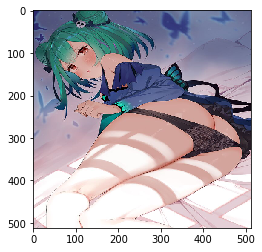

In [110]:
img_rgb = Image.open("./nengdai.jpg").resize((512,512))
img_rgb = np.array(img_rgb)
plt.imshow(img_rgb),img_rgb.shape

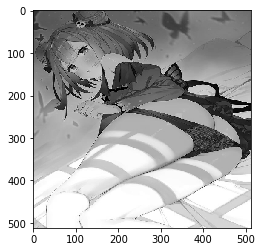

In [111]:
img_gray = np.array(Image.open("./nengdai.jpg").convert('L').resize((512,512)))
plt.imshow(img_gray,cmap = 'gray')

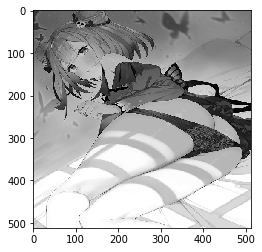

In [112]:
img_lab = color.rgb2lab(img_rgb/255)
img_lab_l = img_lab[:,:,0]
plt.imshow(img_lab_l,cmap = 'gray')

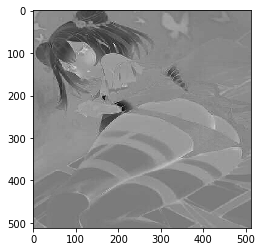

In [113]:
img_lab_a = img_lab[:,:,1]
plt.imshow(img_lab_a,cmap = 'gray') # matplotlib没有专门绘制ab通道的cmap，所以这里只是个示意图，真实色彩不是这样的。

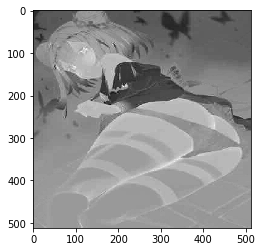

In [114]:
img_lab_b = img_lab[:,:,2]
plt.imshow(img_lab_b,cmap = 'gray') # matplotlib没有专门绘制ab通道的cmap，所以这里只是个示意图，真实色彩不是这样的。

In [115]:
class Net(t.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = t.nn.Sequential(
            t.nn.Conv2d(1,16,3,stride=2,padding=1),
            t.nn.BatchNorm2d(16),
            t.nn.ReLU(),
            t.nn.Upsample(scale_factor=2)
        )
        self.conv2 = t.nn.Sequential(
            t.nn.Conv2d(16,32,3,2,1),
            t.nn.BatchNorm2d(32),
            t.nn.ReLU(),
            t.nn.Upsample(scale_factor=2)
        )
        self.conv3 = t.nn.Sequential(
            t.nn.Conv2d(32,16,3,2,1),
            t.nn.BatchNorm2d(16),
            t.nn.ReLU(),
            t.nn.Upsample(scale_factor=2)
        )
        self.conv4 = t.nn.Sequential(
            t.nn.Conv2d(16,2,3,2,1),
            t.nn.BatchNorm2d(2),
            t.nn.ReLU(),
            t.nn.Upsample(scale_factor=2)
        )
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

In [116]:
img_gray = img_gray[:,:,np.newaxis]
img_lab_l = img_lab_l[:,:,np.newaxis]
img_gray.shape,img_lab_l.shape

((512, 512, 1), (512, 512, 1))

In [117]:
x_train = img_lab_l

In [118]:
y_train = img_lab[:,:,1:3]
y_train /= 128

In [119]:
y_train.shape

(512, 512, 2)

In [120]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [121]:
x_train,y_train = transform(x_train),transform(y_train)
x_train,y_train = x_train.float(),y_train.float()

In [122]:
x_train,y_train = x_train.view(-1,1,512,512),y_train.view(-1,2,512,512)

In [123]:
x_train.shape,y_train.shape

(torch.Size([1, 1, 512, 512]), torch.Size([1, 2, 512, 512]))

In [124]:
net = Net()
net

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
  )
  (conv4): Sequential(
    (0): Conv2d(16, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_

In [125]:
EPOCHS = 500
LR = 0.01
criterion = t.nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=LR,weight_decay=0.0)

In [126]:
for epoch in tqdm(range(EPOCHS)):
    index=0
    if epoch % 100 == 0:
        for param_group in optimizer.param_groups:
            LR = LR * 0.9
            param_group['lr'] = LR
    prediction = net.forward(x_train)
    loss = criterion(prediction,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
loss

tensor(0.0078, grad_fn=<MseLossBackward>)

In [127]:
net.eval()
prediction = net.forward(x_train)
prediction *= 128

In [128]:
prediction = prediction[0].data.numpy()
x_train = x_train[0].data.numpy()
x_train.shape,prediction.shape

((1, 512, 512), (2, 512, 512))

In [129]:
result = np.zeros((512,512,3))
result[:,:,0] = x_train[0]
result[:,:,1] = prediction[0]
result[:,:,2] = prediction[1]

In [130]:
result_rgb = color.lab2rgb(result)

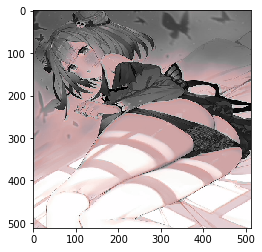

In [131]:
plt.imshow(result_rgb)

In [132]:
output = Image.fromarray(np.uint8(result_rgb*255))

In [133]:
output = output.resize((943, 1334),Image.ANTIALIAS)

In [134]:
output.save("1.jpg")